In [1]:
try:
    from bs4 import beautifulsoup4
except:
    !pip install beautifulsoup4


You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import matplotlib as plt
import pandas as pd
import numpy as np
import bs4
import re
from urllib.request import urlopen as url_request
from bs4 import BeautifulSoup as soup

In [3]:
def get_soup(link):
    url_client = url_request(link)
    page_body = url_client.read()
    url_client.close()
    return soup(page_body, 'html.parser')

In [4]:

def get_salary_estimators(page_soup):
    salary_estimators_soup = page_soup.select("div#SALARY_rbo ul.rbList li")

    salary_estimators =[]

    for salary_estimator_soup in salary_estimators_soup:

        link = salary_estimator_soup.find("a")["href"]

        salary = int(salary_estimator_soup\
            .find("span",{"class": "rbLabel"}).string\
            .replace("$","")\
            .replace(",",""))
        count = int(salary_estimator_soup\
            .find("span",{"class": "rbCount"}).string.\
            replace("(","")\
            .replace(")",""))

        salary_estimators.append((link,salary,count))

    salary_estimators.reverse()
    return salary_estimators

In [5]:
def get_positions(site, location, jobtitle, skills_search_words):

    # Empty list for job_title, company_name, location, job_description, job skills
    titles = []
    company_names = []
    location_names = []
    job_descriptions = []
    job_ids = []
    salaries = []
    
    # Empty Skills data dict construction
    skills_data = {}
    for skill in skills_search_words:
        skills_data[skill]=[] 

    # Compiling start query string
    start_url = site + '/jobs?q=' + jobtitle.replace(' ', '+') + '&l=' + location.replace(' ', '+')
    
    # getting first page
    page_soup = get_soup(start_url)
    
    # creating dict with compensations filters
    salary_estimators = get_salary_estimators(page_soup)
    
    #print(salary_estimators)
     
    # test estimator    
    # salary_estimators = [('/q-data-scientist-$135,000-l-New-York-jobs.html', 135000, 10)]

    # walk throught each salary estimator
    for salary_estimator in salary_estimators:
        (initial_url, salary, count) = salary_estimator

        print(f'Parsing positions with {salary}+ compensation({count})')
        
        # at first we have something like   https://www.indeed.com/q-data-scientist-$135,000-l-New-York-jobs.html
        # and we should retrive url from pagination
        parse_url = initial_url

        # Loop over vacancies (10 at each page)
        for i in range(0, count, 10):
            # html parsing Indeed job portal page
            print(f'    Processed - {i}')
            
            # first entrance
            if (initial_url==parse_url):

                page_soup = get_soup(site+initial_url)

                # calculation iterable url
                parse_url = page_soup.find("div", {"class": "pagination"}).find("a")["href"]
                parse_url = re.search('(.*)start=', parse_url).group(0)

            else:
                page_soup = get_soup(site + parse_url+str(i))

            # getting jobs from list
            jobs = page_soup.findAll("div", class_="row")
            for job in jobs:

                job_url = job.a["href"]
                # parsing position ID
                try:
                    job_id = re.search('clk\?jk=(.*)&fccid', job_url).group(1)

                    #skip already parsed jobs
                    if job_id in job_ids:
                        continue
                    job_ids.append(job_id)
                except:
                    continue

                salaries.append(salary)

                # extract job_title
                try:
                    titles.append(job.a["title"])
                except:
                    titles.append("NA")

                # extract company_name
                try:
                    company_names.append(job.find("span", class_="company").text.strip())
                except:
                    company_names.append("NA")

                # extract location
                try:
                    location_names.append(job.find(class_="location").text)
                except:
                    location_names.append("NA")

                # extract description from position view
                job_soup = get_soup(site + job_url)

                job_description = job_soup.findAll("div", class_="jobsearch-JobComponent-description")
                cleantext = soup(str(job_description), 'lxml').text
                try:
                    job_descriptions.append(cleantext)
                except:
                    job_descriptions.append("NA")
                    
                # Skills
                for (skill, search_words) in skills_search_words.items():
    
                    # rearching
                    skill_data = skills_data.get(skill);
                
                    # loop search words
                    is_in_text = False
            
                    for search_word in search_words:
                        if skill.lower() in cleantext.lower():
                            is_in_text = True
                            break
                            
                    # updating
                    skill_data.append('1' if is_in_text else '0')
                    skills_data[skill]=skill_data 
    
    
    data = {'Job_ID': job_ids, 'Salary': salaries, 'Job_Title': titles, 'Company_Name': company_names, 'Location': location_names,
         'Job_Description': job_descriptions}
    
    for (skill, skill_data) in skills_data.items():
        data[skill] = skill_data
    
    return pd.DataFrame(data)

In [6]:
site = 'https://www.indeed.com'
jobtitle = 'data scientist'
location = 'Sydney'
locations = ['Sydney']
skills_search_words = {
    'Python' : ['python','numpy', 'pandas', 'scikit-learn', 'matplotlib'],
    'R' : [',R ',' R '],
    'Math' : ['math'],
    'Soft Skills': ['leadership','leader','communication'],
    'Artificial Intelligence': ['artificial intelligence','AI'],
    'Deep learning': ['deep learning'],
    'Business Skils': ['collaborating','stakeholder','management'],
    'Stats': ['stats, statistics'],
    'Machine Learning': ['machine learning'],
    'Excel': ['excel'],
    'Matlab': ['matlab'],
    'SAS': ['sas'],
    'SQL': ['sql'],
    'SPSS': ['spss'],
    'Big Data': ['hadoop','spark'],
    'Econometrics': ['econometrics','economet']
}
        
df = get_positions(site, location, jobtitle, skills_search_words)
#df.to_csv('Indeed_job_vacancies.csv')
print(df.iloc[:4,:])

Parsing positions with 121600+ compensation(15)
    Processed - 0
    Processed - 10
Parsing positions with 110300+ compensation(35)
    Processed - 0
    Processed - 10
    Processed - 20
    Processed - 30
Parsing positions with 108000+ compensation(40)
    Processed - 0
    Processed - 10
    Processed - 20
    Processed - 30
Parsing positions with 86100+ compensation(55)
    Processed - 0
    Processed - 10
    Processed - 20
    Processed - 30
    Processed - 40
    Processed - 50
Parsing positions with 77000+ compensation(66)
    Processed - 0
    Processed - 10
    Processed - 20
    Processed - 30
    Processed - 40
    Processed - 50
    Processed - 60
             Job_ID  Salary                  Job_Title      Company_Name  \
0  fa1e1f126f69be85  121600      GEOINT Data Scientist  Royce Geospatial   
1  5b9e323aa0649419  121600             Data Scientist   Macro Solutions   
2  a88a6935bf0021a5  121600             Data Scientist      Systems Plus   
3  c5637e5fd223fc98  12160

In [9]:
print(df.columns.values)

['Job_ID' 'Salary' 'Job_Title' 'Company_Name' 'Location' 'Job_Description'
 'Python' 'R' 'Math' 'Soft Skills' 'Artificial Intelligence'
 'Deep learning' 'Business Skils' 'Stats' 'Machine Learning' 'Excel'
 'Matlab' 'SAS' 'SQL' 'SPSS' 'Big Data' 'Econometrics']


In [13]:
skills = df.iloc[:, 6:]

In [17]:
print(skills.iloc[:5, :])

  Python  R Math Soft Skills Artificial Intelligence Deep learning  \
0      1  1    1           0                       0             0   
1      1  1    1           0                       0             0   
2      1  1    1           0                       0             0   
3      1  1    0           0                       0             1   
4      1  1    0           0                       0             0   

  Business Skils Stats Machine Learning Excel Matlab SAS SQL SPSS Big Data  \
0              0     0                0     0      0   1   1    0        1   
1              0     0                0     0      0   0   0    0        1   
2              0     0                0     0      0   0   0    0        0   
3              0     0                1     0      0   0   0    0        0   
4              0     0                1     0      0   0   1    0        0   

  Econometrics  
0            0  
1            0  
2            0  
3            0  
4            0  


In [18]:
test = skills.iloc[:5,:]

In [19]:
t = test.values
print(t)

[['1' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '0' '1' '0']
 ['1' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0']
 ['1' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['1' '1' '0' '0' '0' '1' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0']
 ['1' '1' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '1' '0' '0' '0']]


In [20]:
print(t.shape)

(5, 16)


In [30]:
tt = np.transpose(t)
print(tt)
print(tt.shape)

[['1' '1' '1' '1' '1']
 ['1' '1' '1' '1' '1']
 ['1' '1' '1' '0' '0']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '1' '0']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '1' '1']
 ['0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0']
 ['1' '0' '0' '0' '0']
 ['1' '0' '0' '0' '1']
 ['0' '0' '0' '0' '0']
 ['1' '1' '0' '0' '0']
 ['0' '0' '0' '0' '0']]
(16, 5)


In [26]:
from scipy.spatial.distance import pdist, squareform

In [28]:
test_d_j = pdist(tt, metric='Jaccard')
print(test_d_j)

[0.         0.4        1.         1.         0.8        1.
 1.         0.6        1.         1.         0.8        0.6
 1.         0.6        1.         0.4        1.         1.
 0.8        1.         1.         0.6        1.         1.
 0.8        0.6        1.         0.6        1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.66666667 0.75       1.         0.33333333 1.
 0.         1.         0.         0.         1.         0.
 0.         1.         1.         0.         1.         0.
 1.         0.         0.         1.         0.         0.
 1.         1.         0.         1.         0.         1.
 1.         0.5        1.         1.         1.         1.
 1.         1.         1.         0.         1.         0.
 0.         1.         1.         0.         1.         0.
 1.         0.         0.         1.         1.         0.
 1.         0.         1.         1.         1.         0.66666667
 1.         1.         1.         0.         1.

In [31]:
test_d_j2 = pdist(t, metric='Jaccard')
dist = squareform(test_d_j2)
print(dist)

[[0.         0.33333333 0.5        0.75       0.57142857]
 [0.33333333 0.         0.25       0.66666667 0.66666667]
 [0.5        0.25       0.         0.6        0.6       ]
 [0.75       0.66666667 0.6        0.         0.4       ]
 [0.57142857 0.66666667 0.6        0.4        0.        ]]


In [33]:
def test_distance_metric(ar, metric):
    test_d = pdist(ar, metric = metric)
    dist = squareform(test_d)
    return dist

In [36]:
d_jaccard = test_distance_metric(t, 'Jaccard')
print(d_jaccard)

[[0.         0.33333333 0.5        0.75       0.57142857]
 [0.33333333 0.         0.25       0.66666667 0.66666667]
 [0.5        0.25       0.         0.6        0.6       ]
 [0.75       0.66666667 0.6        0.         0.4       ]
 [0.57142857 0.66666667 0.6        0.4        0.        ]]


In [37]:
d_cosine = test_distance_metric(t, 'cosine')
print(d_cosine)

[[0.         0.18350342 0.29289322 0.59175171 0.38762756]
 [0.18350342 0.         0.1339746  0.5        0.5       ]
 [0.29289322 0.1339746  0.         0.42264973 0.42264973]
 [0.59175171 0.5        0.42264973 0.         0.25      ]
 [0.38762756 0.5        0.42264973 0.25       0.        ]]


In [38]:
X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])

In [39]:
print(X.shape)

(10, 2)


In [41]:
print(tt.shape)

(16, 5)


In [43]:
d_jaccard = test_distance_metric(tt, 'Jaccard')
print(d_jaccard.shape)

(16, 16)


In [45]:
print(1-d_jaccard)

[[1.         1.         0.6        0.         0.         0.2
  0.         0.         0.4        0.         0.         0.2
  0.4        0.         0.4        0.        ]
 [1.         1.         0.6        0.         0.         0.2
  0.         0.         0.4        0.         0.         0.2
  0.4        0.         0.4        0.        ]
 [0.6        0.6        1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.33333333
  0.25       0.         0.66666667 0.        ]
 [0.         0.         0.         1.         1.         0.
  1.         1.         0.         1.         1.         0.
  0.         1.         0.         1.        ]
 [0.         0.         0.         1.         1.         0.
  1.         1.         0.         1.         1.         0.
  0.         1.         0.         1.        ]
 [0.2        0.2        0.         0.         0.         1.
  0.         0.         0.5        0.         0.         0.
  0.         0.         0.       

In [46]:
test_d_j = pdist(tt, metric='Jaccard')

/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


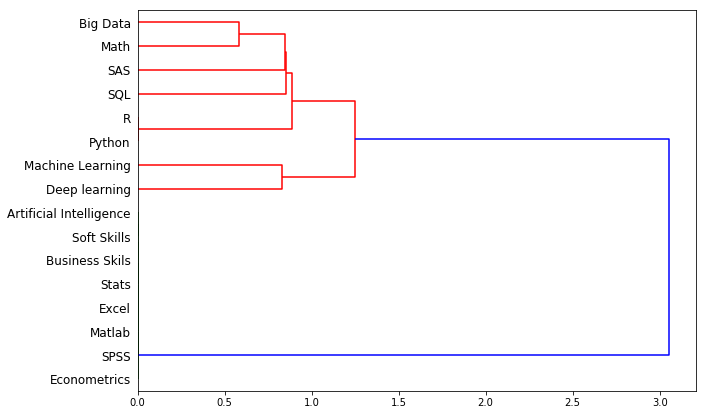

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(d_jaccard, 'single')

#labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='right',
            labels=skills.columns.values,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


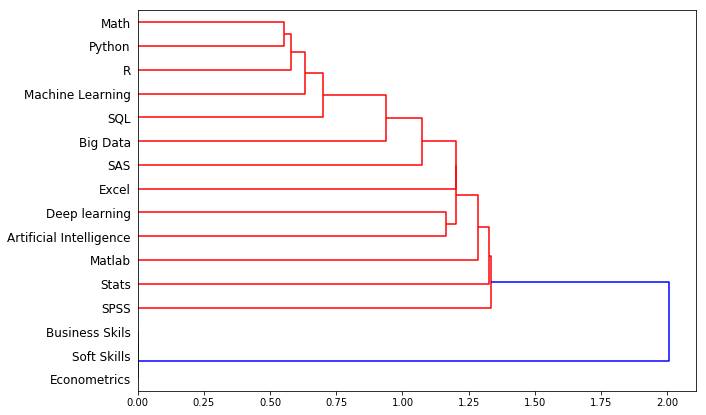

In [50]:
skills_vec = np.transpose(skills.values)
d_jaccard_all = test_distance_metric(skills_vec, 'Jaccard')
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(d_jaccard_all, 'single')

#labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='right',
            labels=skills.columns.values,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()